# **Reinforcement learning : Puissance 4**

Le but de ce script est d'implémenter un agent capable de jouer au jeu Puissance 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Création de l'environnement

In [21]:
NB_ROWS = 6
NB_COLUMNS = 7

In [72]:
class Game:
    """
    Class that describes a game being played
    """
    def __init__(self, nb_rows=6, nb_columns=7, nb_players=2):
        self.nb_rows = nb_rows
        self.nb_columns = nb_columns
        self.nb_players = nb_players
        self.grid = np.zeros((nb_rows, nb_columns))
        self.turn = 0
        self.nb_steps = 0 # Total number of steps in the game
        
    def is_draw(self):
        return self.nb_steps == self.nb_rows*self.nb_columns
        
    def is_legal(self, column):
        # Takes as input a column and return whether it is possible or not to put a token or the column (True or False)
        col_values = self.grid[:, column]
        non_zeros, = np.where(col_values == 0)
        return not (len(non_zeros) == 0)
    
    def set_token(self, column):
        # Takes as input a column, and in the move is legal, put a token in the column
        try:
            assert self.is_legal(column)
        except:
            raise Exception("The move is not legal. Column {} is already filled".format(column))
        
        row_index = np.where(self.grid[:, column] == 0)[0][0]
        player_token = 1
        if self.turn == 1:
            player_token = -1
            
        self.grid[row_index][column] = player_token
        
        self.turn = (self.turn + 1) % self.nb_players
        self.nb_steps += 1
        
    def won(self, player_id):
        # Return True if the player n°player_id won, False otherwise
        token_player = 1
        if player_id == 1:
            token_player = -1
            
        for row in range(self.nb_rows):
            for column in range(self.nb_columns):
                current_token = self.grid[row][column]
                if current_token == token_player:
                    token_array = token_player*np.ones(3)
                    
                    if np.array_equal(self.grid[row-3:row, column], token_array):
                        return True
                    
                    elif np.array_equal(self.grid[row, column-3:column], token_array):
                        return True
                    
                    elif np.array_equal(self.grid[row-3:row, column-3:column].diagonal(), token_array):
                        return True
                    
        return False
    
    def get_observation(self):
        # Returns the observation that the agent makes
        return self.grid
    
    def render(self):
        # Displays the current state of the game
        X = []
        Y = []
        colors = []
        color_player1 = np.array([210, 200, 0]) / 255
        color_player2 = np.array([255, 0, 0]) / 255
        for row in range(self.nb_rows):
            for col in range(self.nb_columns):
                token = self.grid[row, col]
                if token == 1 or token == -1:
                    Y.append(row)
                    X.append(col)
                    
                    if token == 1:
                        colors.append(color_player1)
                    elif token == -1:
                        colors.append(color_player2)
                    
        plt.scatter(X, Y, color=colors, s=600)
        plt.xticks(list(range(-1, self.nb_columns+2)))
        plt.yticks(list(range(-1, self.nb_rows+2)))
        plt.grid()
        plt.show()

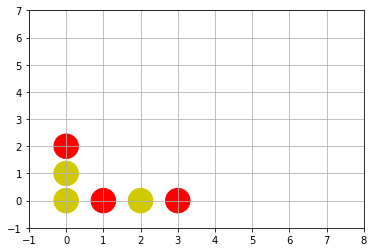

In [46]:
game = Game()

game.set_token(0)
game.set_token(1)
game.set_token(0)
game.set_token(0)
game.set_token(2)
game.set_token(3)
game.render()

In [123]:
class Env:
    """
    Class that represents the environment in which the agent is. 
    The agent is going to do multiple games in the environment
    """
    def __init__(self, actions=np.arange(NB_COLUMNS), nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_players=2):
        self.nb_rows = nb_rows
        self.nb_columns = nb_columns
        self.nb_players = nb_players
        self.game = Game(nb_rows=nb_rows, nb_columns=nb_columns, nb_players=nb_players)
        self.winners = np.array([False, False])
        self.actions = actions
        self.nb_actions = len(actions)
        
    def step(self, action):
        # Takes an action, which is the index of the column where we want to put a token in

        # Tour de l'agent
        observation = self.game.get_observation()
        self.game.set_token(self.actions[action])
        next_observation = self.game.get_observation()
        reward = 0
        game_finished = False
        
        if self.game.won(0):
            self.winners[0] = True
            reward = 1
            game_finished = True
            
        elif self.game.is_draw():
            reward = -1
            game_finished = True

        else:
            # Tour du joueur 2
            action_environment = np.random.choice([i for i in range(self.nb_actions) if self.game.is_legal(i)])
            self.game.set_token(self.actions[action_environment])
            next_observation = self.game.get_observation()

            if self.game.won(1):
                self.winners[1] = True
                reward = -10
                game_finished = True
                
            elif self.game.is_draw():
                reward = -1
                game_finished = True

        return observation, reward, next_observation, game_finished


    def is_game_finished(self):
        return (True in self.winners)
    
    def reset(self):
        self.game = Game(nb_rows=self.nb_rows, nb_columns=self.nb_columns, nb_players=self.nb_players)
        self.winners = np.array([False, False])

    def get_observation(self):
      return self.game.get_observation()

    def render(self):
      self.game.render()

# 2) On définit l'estimateur des valeurs d'actions

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [300]:
class Estimator(keras.Model):
  def __init__(self, nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_actions=NB_COLUMNS):
    super().__init__()
    self.conv1 = layers.Conv2D(8, (4, 1), padding='same', activation='relu', input_shape=(nb_rows, nb_columns, 1))
    self.conv2 = layers.Conv2D(8, (1, 4), padding='same', activation='relu', input_shape=(nb_rows, nb_columns, 1))
    self.conv3 = layers.Conv2D(8, (4, 4), padding='same', activation='relu', input_shape=(nb_rows, nb_columns, 1))

    self.conv4 = layers.Conv2D(8, (2, 2), padding='same', activation='relu')
    self.conv5 = layers.Conv2D(8, (2, 2), activation='relu')
    self.flatten = layers.Flatten()
    self.pooling = layers.MaxPooling2D((2,2))
    self.dense1 = layers.Dense(32, activation='relu')
    self.dense2 = layers.Dense(nb_actions, activation='linear')

  def call(self, x):
    x = tf.expand_dims(x, axis=-1)
    x = tf.expand_dims(x, axis=0)

    x1 = self.conv1(x)
    x2 = self.conv2(x)
    x3 = self.conv3(x)
    
    x = tf.concat([x1, x2, x3], axis=-1)
    x = self.conv4(x)
    
    x = self.pooling(x)
    x = self.conv5(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = x[0]
    return x

Q = Estimator()
x = tf.random.uniform((NB_ROWS, NB_COLUMNS))
Q(x).shape

TensorShape([7])

# 3) Définition des politiques

In [301]:
def set_impossible_actions_to_nan(action_values, illegal_actions):
  # Takes an array of action_values for a given observation and a given action, and sets the impossible actions to np.nan, and returns the array
  for index in illegal_actions:
    action_values[index] = np.nan
  
  return action_values

In [302]:
def avare(Q, observation, illegal_actions, nb_actions=NB_COLUMNS):
  action_values = Q(observation).numpy()
  action_values = set_impossible_actions_to_nan(action_values, illegal_actions)

  return np.nanargmax(action_values)


def epsilon_avare(Q, observation, illegal_actions, nb_actions=NB_COLUMNS, epsilon=0.1):
  action_values = Q(observation).numpy()
  action_values = set_impossible_actions_to_nan(action_values, illegal_actions)

  nb_legal_actions = (nb_actions - len(illegal_actions))

  p = (epsilon/nb_legal_actions)*np.ones(nb_actions)
  p[np.nanargmax(action_values)] += (1 - epsilon)
  for index in illegal_actions:
    p[index] = 0

  return np.random.choice([i for i in range(nb_actions)], p=p)


def random(Q, observation, illegal_actions, nb_actions=NB_COLUMNS):
  return np.random.choice([i for i in range(nb_actions) if i not in illegal_actions])

# 4) Définition de la mémoire

In [303]:
class Memory:
  def __init__(self):
    # self.observations = np.array([[]])
    self.observations = []
    self.actions = np.array([])
    self.rewards = np.array([])
    # self.next_observations = np.array([])
    self.next_observations = []
    self.dones = np.array([]) # True if game finished, False otherwise

  def remember(self, obs, act, rew, next_obs, done):
    # self.observations = np.append(self.observations, obs)
    self.observations.append(obs)
    self.actions = np.append(self.actions, act)
    self.rewards = np.append(self.rewards, rew)
    # self.next_observations = np.append(self.next_observations, next_obs)
    self.next_observations.append(next_obs)
    self.dones = np.append(self.dones, done)

  def reset(self):
    self.observations = np.array([])
    self.actions = np.array([])
    self.rewards = np.array([])
    self.next_observations = np.array([])
    self.done = np.array([])

# 5) Boucle de jeu

In [304]:
actions = np.arange(NB_COLUMNS)
nb_actions = len(actions)

env = Env(actions=actions, nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_players=2)
Q = Estimator(nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_actions=nb_actions)
memory = Memory()

policy = epsilon_avare
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [305]:
def train_step(model, memory, optimizer, gamma=0.99):
    agent_observations = np.array(memory.observations)
    agent_actions = memory.actions
    agent_rewards = memory.rewards
    agent_next_observations = np.array(memory.next_observations)
    agent_dones = memory.dones

    for obs, act, rew, next_obs, done in zip(agent_observations, agent_actions, agent_rewards, agent_next_observations, agent_dones):
      with tf.GradientTape() as tape:
          action_values = model(obs, training=True)
          G_current = action_values[int(act)]

          done = 1 if done else 0 # Change True to 1 and Fales to 0

          max_action_values_next_obs = np.argmax(model(next_obs, training=True))
          G_next = (1-done)*max_action_values_next_obs

          loss = (G_current - (rew + G_next))**2

          gradients = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [306]:
"""
il faudrait implémenter une sorte de batch_size, pour ne pas entrainer sur chaque exemple séparément
"""

EPOCHS = 20
nb_games_before_update = 25
nb_games_test = 10
nb_wins_history = []

for epoch in range(EPOCHS):
    print("--- Epoch {}/{} ---".format(epoch+1, EPOCHS))

    # Train
    for _ in range(nb_games_before_update):
        game_finished = False
        while not game_finished:
            # Agent turn
            observation = env.get_observation()
            illegal_actions = [i for i in range(nb_actions) if not env.game.is_legal(i)]
            action = epsilon_avare(Q, observation, illegal_actions=illegal_actions, epsilon=0.8)

            observation, reward, next_observation, game_finished = env.step(action)
            next_observation = env.get_observation()
            memory.remember(observation, action, reward, next_observation, game_finished)
        
        env.reset()

    train_step(Q, memory, optimizer)

    # Test
    nb_wins = 0
    for _ in range(nb_games_test):
        game_finished = False
        while not game_finished:
            # Agent turn
            observation = env.get_observation()
            illegal_actions = [i for i in range(nb_actions) if not env.game.is_legal(i)]
            action = avare(Q, observation, illegal_actions=illegal_actions)

            observation, _, _, game_finished = env.step(action)
        
        if env.game.won(0):
            nb_wins += 1


        env.reset()

    nb_wins_history.append(nb_wins)

    print("{}/{} wins".format(nb_wins, nb_games_test))

--- Epoch 1/20 ---
8/10 wins
--- Epoch 2/20 ---
9/10 wins
--- Epoch 3/20 ---
8/10 wins
--- Epoch 4/20 ---
7/10 wins
--- Epoch 5/20 ---
7/10 wins
--- Epoch 6/20 ---
8/10 wins
--- Epoch 7/20 ---
9/10 wins
--- Epoch 8/20 ---
7/10 wins
--- Epoch 9/20 ---
8/10 wins
--- Epoch 10/20 ---
8/10 wins
--- Epoch 11/20 ---
8/10 wins
--- Epoch 12/20 ---
7/10 wins
--- Epoch 13/20 ---
8/10 wins
--- Epoch 14/20 ---
9/10 wins
--- Epoch 15/20 ---
5/10 wins
--- Epoch 16/20 ---
9/10 wins
--- Epoch 17/20 ---
8/10 wins
--- Epoch 18/20 ---
4/10 wins
--- Epoch 19/20 ---
5/10 wins
--- Epoch 20/20 ---
9/10 wins


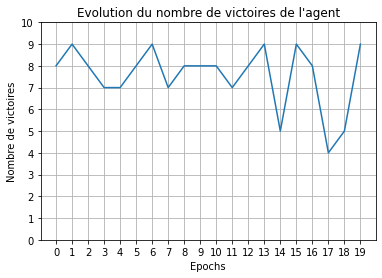

In [307]:
plt.plot(np.arange(EPOCHS), nb_wins_history)
plt.title("Evolution du nombre de victoires de l'agent")
plt.xticks(np.arange(EPOCHS))
plt.yticks([i for i in range(nb_games_test+1)])
plt.xlabel("Epochs")
plt.ylabel("Nombre de victoires")
plt.grid()
plt.show()